# Capstone Project - The Battle of New York Gyms

### Author: Bara Pencikova 
### October 2019


## INTRODUCTION:

The City of New York, or simply New York (NY), is the most populous city in the United States. With an estimated 2018 population of 8,398,748 distributed over a land area of about 784 km2, New York is also the most densely populated major city in the United States. New York City has been described as the cultural, financial, and media capital of the world, and exerts a significant impact upon commerce, entertainment, research, technology, education, politics, tourism, art, fashion, and sports. (source: https://en.wikipedia.org/wiki/New_York_City)


## BUSINESS GOAL DESCRIPTION:

My client is a businessman who spends a lot of time travelling. One of his future business trips will be a long-term stay in New York. Apart from many expected hours sitting at the office my client wants also to stay in a good physical shape, so he wants me to analyze and recommend the best part of New York according to the density of fitness centers, gyms, martial arts dojos and similar facilities. My client doesn’t mind the accommodation, the priority is to have good gyms and/or fitness centers within reach.

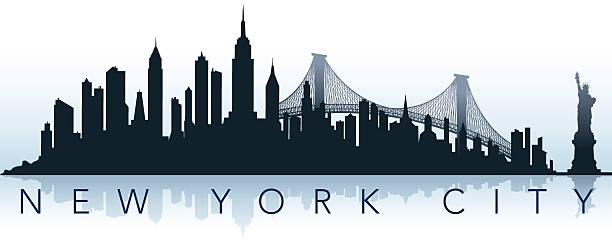

## DATA

For this particular assignment I used the Fourquare data, accessed through API https://developer.foursquare.com/docs/resources/categories the category "Gym / Fitness Center" which has this ID: "4bf58dd8d48988d175941735".


For clustering and segmenting I have used the dataset which contains the New York borroughs and neighborhoods with their latitudes and longitudes. The dataset can be found in the NYU Spatial Data Repository pages: https://geo.nyu.edu/catalog/nyu_2451_34572


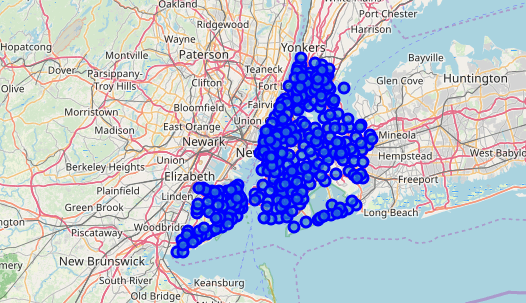

## METHODOLOGY

I have downloaded the data from NYU Spatial Data Repository (GeoJSON file with geolocations) and converted to Pandas dataframe. After that, using the FourSquare data, I explore neighborhoods of New York borroughs for their most frequent gyms and sporting facilities, converting them to OneHot dataframe and merge with the capital cities data.

Using Machine Learning classification method K-Means, I will classify NY neighborhoods into clusters. Finally, each cluster is inspected for typical venue categories that I will present using Word Cluster visualization method.

# Importing libraries

First I will import all the needed libraries..

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize
import urllib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans
import folium

# Getting data

For my assignment I will need the New York borroughs and their associated neighborhoods. I've downloaded the GeoJSON file from the NYU Spatial Data repository: https://geo.nyu.edu/catalog/nyu_2451_34572 

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

I will transform the downloaded file into the pandas dataframe:

In [3]:
neighborhoods_data = newyork_data['features']
# defining the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# define the geolocation data
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


In [4]:
neighborhoods.head(10)

Borough    Neighborhood   Latitude  Longitude
0      Bronx       Wakefield  40.894705 -73.847201
1      Bronx      Co-op City  40.874294 -73.829939
2      Bronx     Eastchester  40.887556 -73.827806
3      Bronx       Fieldston  40.895437 -73.905643
4      Bronx       Riverdale  40.890834 -73.912585
5      Bronx     Kingsbridge  40.881687 -73.902818
6  Manhattan     Marble Hill  40.876551 -73.910660
7      Bronx        Woodlawn  40.898273 -73.867315
8      Bronx         Norwood  40.877224 -73.879391
9      Bronx  Williamsbridge  40.881039 -73.857446

Getting the New York coordinate:

In [5]:
address = 'New York'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

'The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude)

'The geograpical coordinate of New York are 40.7127281, -74.0060152.'

Creating the map of New York and it's neighborhoods, using the folium library:

In [6]:
import folium

map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

FourSquare setup:

In [7]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name'],
                     )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category',
                                      ]
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

FourSquare credentials + defining constants for REST API request:

In [8]:
LIMIT = 500 
radius = 5000 
CLIENT_ID = 'QSHQMVSOBTCDQ2SNY43OT52WN4JD5CBFOLVDGF2JGCVMRUAT'
CLIENT_SECRET = 'IF0ZK5WNA54HMU2LRLFAZXCBHE5SU4IBQSFQGLDDYG1VMQAI'
VERSION = '20191003'

### FourSquare Categories's IDs:

Athletics_and_sports = 4f4528bc4b90abdf24c9de85 - will not be used in the code (just for info/fun, playing with the categories)

Gyms / Fittnes Centers = 4bf58dd8d48988d175941735

In [9]:
newyork_venues_gyms = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d175941735')
newyork_venues_gyms.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2   Co-op City              40.874294              -73.829939   
3   Co-op City              40.874294              -73.829939   
4   Co-op City              40.874294              -73.829939   

                                Venue  Venue Latitude  Venue Longitude  \
0  Mount St Michael's Academy (track)       40.898688       -73.840709   
1                      T Gym & Studio       40.901266       -73.838078   
2                              My Gym       40.872681       -73.829400   
3                     24 Hour Fitness       40.867818       -73.824984   
4    bally's total fitness bartow ave       40.867290       -73.832603   

         Venue Category  
0                 Track  
1  Gym / Fitness Center  
2  Gym / Fitness Center  
3  Gym / Fitness Center  
4  Gym / Fitness Center

In [10]:
newyork_venues_gyms.shape

(5889, 7)

In [11]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('Neighborhood').count()
    
    for n in startDf['Neighborhood']:
        try:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = 0

Group by Neighborhood:

In [12]:
ny_grouped = newyork_venues_gyms.groupby('Neighborhood').count()
ny_grouped

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
Allerton                                       6                       6   
Annadale                                       6                       6   
Arden Heights                                  5                       5   
Arlington                                      1                       1   
Arrochar                                       8                       8   
Arverne                                        1                       1   
Astoria                                       49                      49   
Astoria Heights                               14                      14   
Auburndale                                    17                      17   
Bath Beach                                    22                      22   
Battery Park City                             50                      50   
Bay Ridge                                     39                      39   
Bay Terrace                                   22                      22   
Baychester                                     9                       9   
Bayside                                       19                      19   
Bayswater                                      2                       2   
Bedford Park                                  15                      15   
Bedford Stuyvesant                            32                      32   
Beechhurst                                    18                      18   
Bellaire                                       6                       6   
Belle Harbor                                   3                       3   
Bellerose                                      7                       7   
Belmont                                       12                      12   
Bensonhurst                                   23                      23   
Bergen Beach                                   3                       3   
Blissville                                    13                      13   
Bloomfield                                     7                       7   
Boerum Hill                                   50                      50   
Borough Park                                   8                       8   
Breezy Point                                   2                       2   
Briarwood                                      9                       9   
Brighton Beach                                19                      19   
Broadway Junction                              7                       7   
Bronxdale                                     16                      16   
Brooklyn Heights                              50                      50   
Brookville                                     2                       2   
Brownsville                                   11                      11   
Bulls Head                                    10                      10   
Bushwick                                      47                      47   
Butler Manor                                   2                       2   
Cambria Heights                                2                       2   
Canarsie                                       7                       7   
Carnegie Hill                                 50                      50   
Carroll Gardens                               50                      50   
Castle Hill                                    3                       3   
Castleton Corners                             11                      11   
Central Harlem                                49                      49   
Charleston                                    20                      20   
Chelsea                                       59                      59   
Chinatown                                     50                      50   
City Island                                    1                       1   

One-Hot Encoding (categorical values are converted into the numerical value for entry in the dataset):

In [13]:
ny_onehot = pd.get_dummies(newyork_venues_gyms[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = newyork_venues_gyms['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

Neighborhood  Acupuncturist  Adult Education Center  Athletics & Sports  \
0    Wakefield              0                       0                   0   
1    Wakefield              0                       0                   0   
2   Co-op City              0                       0                   0   
3   Co-op City              0                       0                   0   
4   Co-op City              0                       0                   0   

   Baseball Field  Basketball Court  Bike Shop  Boxing Gym  Building  \
0               0                 0          0           0         0   
1               0                 0          0           0         0   
2               0                 0          0           0         0   
3               0                 0          0           0         0   
4               0                 0          0           0         0   

   Chiropractor  Climbing Gym  Clothing Store  Club House  College Gym  \
0             0             0               0           0            0   
1             0             0               0           0            0   
2             0             0               0           0            0   
3             0             0               0           0            0   
4             0             0               0           0            0   

   College Rec Center  Community Center  Corporate Amenity  Coworking Space  \
0                   0                 0                  0                0   
1                   0                 0                  0                0   
2                   0                 0                  0                0   
3                   0                 0                  0                0   
4                   0                 0                  0                0   

   Cultural Center  Cycle Studio  Dance Studio  Doctor's Office  Dog Run  \
0                0             0             0                0        0   
1                0             0             0                0        0   
2                0             0             0                0        0   
3                0             0             0                0        0   
4                0             0             0                0        0   

   Event Space  Field  Football Stadium  General College & University  Gym  \
0            0      0                 0                             0    0   
1            0      0                 0                             0    0   
2            0      0                 0                             0    0   
3            0      0                 0                             0    0   
4            0      0                 0                             0    0   

   Gym / Fitness Center  Gym Pool  Gymnastics Gym  High School  Hotel  \
0                     0         0               0            0      0   
1                     1         0               0            0      0   
2                     1         0               0            0      0   
3                     1         0               0            0      0   
4                     1         0               0            0      0   

   Martial Arts Dojo  Massage Studio  Medical Center  Non-Profit  Office  \
0                  0               0               0           0       0   
1                  0               0               0           0       0   
2                  0               0               0           0       0   
3                  0               0               0           0       0   
4                  0               0               0           0       0   

   Outdoor Gym  Park  Performing Arts Venue  Physical Therapist  \
0            0     0                      0                   0   
1            0     0                      0                   0   
2            0     0                      0                   0   
3            0     0                      0                   0   
4            0     0         

In [14]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped

Neighborhood  Acupuncturist  Adult Education Center  \
0                     Allerton       0.000000                0.000000   
1                     Annadale       0.000000                0.000000   
2                Arden Heights       0.000000                0.000000   
3                    Arlington       0.000000                0.000000   
4                     Arrochar       0.000000                0.000000   
5                      Arverne       0.000000                0.000000   
6                      Astoria       0.000000                0.000000   
7              Astoria Heights       0.000000                0.000000   
8                   Auburndale       0.000000                0.000000   
9                   Bath Beach       0.000000                0.000000   
10           Battery Park City       0.000000                0.000000   
11                   Bay Ridge       0.000000                0.000000   
12                 Bay Terrace       0.000000                0.045455   
13                  Baychester       0.000000                0.000000   
14                     Bayside       0.000000                0.000000   
15                   Bayswater       0.000000                0.000000   
16                Bedford Park       0.000000                0.000000   
17          Bedford Stuyvesant       0.000000                0.000000   
18                  Beechhurst       0.000000                0.000000   
19                    Bellaire       0.000000                0.000000   
20                Belle Harbor       0.000000                0.000000   
21                   Bellerose       0.000000                0.000000   
22                     Belmont       0.000000                0.000000   
23                 Bensonhurst       0.000000                0.000000   
24                Bergen Beach       0.000000                0.000000   
25                  Blissville       0.000000                0.000000   
26                  Bloomfield       0.000000                0.000000   
27                 Boerum Hill       0.000000                0.000000   
28                Borough Park       0.000000                0.000000   
29                Breezy Point       0.000000                0.000000   
30                   Briarwood       0.000000                0.000000   
31              Brighton Beach       0.000000                0.000000   
32           Broadway Junction       0.000000                0.000000   
33                   Bronxdale       0.000000                0.000000   
34            Brooklyn Heights       0.000000                0.000000   
35                  Brookville       0.000000                0.000000   
36                 Brownsville       0.000000                0.000000   
37                  Bulls Head       0.000000                0.000000   
38                    Bushwick       0.000000                0.000000   
39                Butler Manor       0.000000                0.000000   
40             Cambria Heights       0.000000                0.000000   
41                    Canarsie       0.000000                0.000000   
42               Carnegie Hill       0.000000                0.000000   
43             Carroll Gardens       0.000000                0.000000   
44                 Castle Hill       0.000000                0.000000   
45           Castleton Corners       0.000000                0.000000   
46              Central Harlem       0.000000                0.000000   
47                  Charleston       0.000000                0.000000   
48                     Chelsea       0.000000                0.000000   
49                   Chinatown       0.000000                0.000000   
50                 City Island       0.000000                0.000000   
51                   City Line       0.000000                0.000000   
52                Civic Center       0.000000                0.000000   
53           Claremont Village       0.000000                0.000000   
54 

Definning the function that returns the most common venues:

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton     Martial Arts Dojo                   Gym   
1       Annadale                   Gym    Weight Loss Center   
2  Arden Heights                   Gym  Gym / Fitness Center   
3      Arlington  Gym / Fitness Center           Yoga Studio   
4       Arrochar     Martial Arts Dojo                   Gym   

  3rd Most Common Venue 4th Most Common Venue         5th Most Common Venue  \
0                 Track           Yoga Studio              Community Center   
1  Gym / Fitness Center           Yoga Studio              Community Center   
2                 Track           Yoga Studio              Community Center   
3        Gymnastics Gym                   Gym  General College & University   
4  Gym / Fitness Center           College Gym                   Yoga Studio   

          6th Most Common Venue         7th Most Common Venue  \
0  General College & University              Football Stadium   
1  General College & University              Football Stadium   
2  General College & University              Football Stadium   
3              Football Stadium                         Field   
4             Corporate Amenity  General College & University   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                 Field           Event Space                Dog Run  
1                 Field           Event Space                Dog Run  
2                 Field           Event Space                Dog Run  
3           Event Space               Dog Run        Doctor's Office  
4      Football Stadium                 Field            Event Space

Setting the number of clusters to 5:

In [17]:
kclusters = 5

ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 2, 3, 0, 3, 0, 3, 3, 1])

In [18]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = neighborhoods
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head()

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             3.0   
1   Bronx   Co-op City  40.874294 -73.829939             3.0   
2   Bronx  Eastchester  40.887556 -73.827806             1.0   
3   Bronx    Fieldston  40.895437 -73.905643             1.0   
4   Bronx    Riverdale  40.890834 -73.912585             1.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0  Gym / Fitness Center                 Track           Yoga Studio   
1  Gym / Fitness Center                   Gym           Yoga Studio   
2                   Gym  Gym / Fitness Center     Martial Arts Dojo   
3                   Gym  Gym / Fitness Center           Yoga Studio   
4                   Gym  Gym / Fitness Center           Yoga Studio   

  4th Most Common Venue         5th Most Common Venue  \
0      Community Center                           Gym   
1        Gymnastics Gym  General College & University   
2           Yoga Studio             Corporate Amenity   
3     Martial Arts Dojo            Athletics & Sports   
4     Martial Arts Dojo            Athletics & Sports   

          6th Most Common Venue         7th Most Common Venue  \
0  General College & University              Football Stadium   
1              Football Stadium                         Field   
2  General College & University              Football Stadium   
3                   High School                         Track   
4             Corporate Amenity  General College & University   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                 Field           Event Space                Dog Run  
1           Event Space               Dog Run        Doctor's Office  
2                 Field           Event Space                Dog Run  
3                Temple    College Rec Center       Football Stadium  
4      Football Stadium                 Field            Event Space

In [19]:
#renaming the clusters
ny_merged['Cluster Labels'] = ny_merged['Cluster Labels'].replace([4, 4.0], 5)
ny_merged['Cluster Labels'] = ny_merged['Cluster Labels'].replace([3, 3.0], 4)
ny_merged['Cluster Labels'] = ny_merged['Cluster Labels'].replace([2, 2.0], 3)
ny_merged['Cluster Labels'] = ny_merged['Cluster Labels'].replace([1, 1.0], 2)
ny_merged['Cluster Labels'] = ny_merged['Cluster Labels'].replace([0, 0.0], 1)

In [20]:
#exploring the counts of each cluster
ny_merged["Cluster Labels"].value_counts()

2.0    138
4.0     51
1.0     45
5.0     36
3.0     31
Name: Cluster Labels, dtype: int64

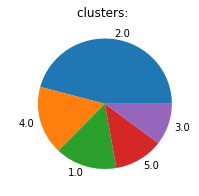

In [22]:
plotx = ny_merged["Cluster Labels"].value_counts()
plot_x = plotx.plot.pie(figsize=(3, 3), label = ' ', title = 'clusters: ' )

In [23]:
ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
12        City Island     Martial Arts Dojo           Yoga Studio   
28        Throgs Neck     Martial Arts Dojo              Gym Pool   
38      Schuylerville     Martial Arts Dojo                   Gym   
39     Edgewater Park                   Gym     Martial Arts Dojo   
41          Olinville                   Gym     Martial Arts Dojo   
57         Kensington                   Gym     Martial Arts Dojo   
58    Windsor Terrace                   Gym     Martial Arts Dojo   
71      Cypress Hills                   Gym     Martial Arts Dojo   
76        Mill Island              Gym Pool                   Gym   
77    Manhattan Beach     Martial Arts Dojo                   Gym   
80       Borough Park     Martial Arts Dojo                   Gym   
82    Gerritsen Beach                   Gym  Gym / Fitness Center   
91       Bergen Beach              Gym Pool     Martial Arts Dojo   
129           Astoria                   Gym  Gym / Fitness Center   
142           Maspeth        Gymnastics Gym                   Gym   
147        Ozone Park                   Gym     Martial Arts Dojo   
148  South Ozone Park  Gym / Fitness Center     Martial Arts Dojo   
150        Whitestone  Gym / Fitness Center     Martial Arts Dojo   
158     Fresh Meadows                   Gym     Martial Arts Dojo   
162    Queens Village     Martial Arts Dojo                   Gym   
170      Far Rockaway                   Gym  Gym / Fitness Center   
175       Bay Terrace                   Gym     Martial Arts Dojo   
183   Jamaica Estates                   Gym     Martial Arts Dojo   
185         Hillcrest                   Gym     Martial Arts Dojo   
202       Grymes Hill     Martial Arts Dojo                   Gym   
203         Todt Hill     Martial Arts Dojo           Yoga Studio   
205     Port Richmond     Martial Arts Dojo  Gym / Fitness Center   
211          New Dorp     Martial Arts Dojo                   Gym   
212           Oakwood     Martial Arts Dojo                   Gym   
228          Arrochar     Martial Arts Dojo                   Gym   
229          Grasmere     Martial Arts Dojo                   Gym   
232     Midland Beach  Gym / Fitness Center     Martial Arts Dojo   
233        Grant City     Martial Arts Dojo  Gym / Fitness Center   
234    New Dorp Beach     Martial Arts Dojo  Gym / Fitness Center   
235       Bay Terrace                   Gym     Martial Arts Dojo   
245        Bloomfield     Martial Arts Dojo        Gymnastics Gym   
253           Clifton           Yoga Studio                   Gym   
255      Emerson Hill                   Gym         Acupuncturist   
259    Remsen Village     Martial Arts Dojo                   Gym   
262        Mill Basin                   Gym     Martial Arts Dojo   
264            Utopia     Martial Arts Dojo    Weight Loss Center   
265           Pomonok     Martial Arts Dojo           Yoga Studio   
294             Malba     Martial Arts Dojo  Gym / Fitness Center   
298          Allerton     Martial Arts Dojo                   Gym   
305         Fox Hills  Gym / Fitness Center                   Gym   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
12      Corporate Amenity  Gym / Fitness Center                   Gym   
28                    Gym     Corporate Amenity  Gym / Fitness Center   
38            Yoga Studio     Corporate Amenity  Gym / Fitness Center   
39               Gym Pool     Corporate Amenity  Gym / Fitness Center   
41   Gym / Fitness Center           Yoga Studio     Corporate Amenity   
57            Yoga Studio  Gym / Fitness Center           Outdoor Gym   
58            Yoga Studio        Pilates Studio  Gym / Fitness Center   
71   Gym / Fitness Center           Yoga Studio     Corporate Amenity   
76      Martial Arts Dojo     Corporate Amenity  Gym / Fitness Center   
77            Yoga Studio              Gym Pool        Pilates Studio   
80            Yoga Studio     C

In [24]:
ny_merged.loc[ny_merged['Cluster Labels'] == 2, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
2                  Eastchester                   Gym  Gym / Fitness Center   
3                    Fieldston                   Gym  Gym / Fitness Center   
4                    Riverdale                   Gym  Gym / Fitness Center   
5                  Kingsbridge                   Gym  Gym / Fitness Center   
6                  Marble Hill                   Gym  Gym / Fitness Center   
10                  Baychester  Gym / Fitness Center                   Gym   
11              Pelham Parkway                   Gym  Gym / Fitness Center   
13                Bedford Park                   Gym  Gym / Fitness Center   
14          University Heights                   Gym  Gym / Fitness Center   
15              Morris Heights                   Gym  Gym / Fitness Center   
16                     Fordham  Gym / Fitness Center                   Gym   
18                  West Farms                   Gym  Gym / Fitness Center   
19                High  Bridge                   Gym  Gym / Fitness Center   
20                     Melrose  Gym / Fitness Center                   Gym   
21                  Mott Haven                   Gym  Gym / Fitness Center   
23                    Longwood  Gym / Fitness Center                   Gym   
24                 Hunts Point  Gym / Fitness Center                   Gym   
25                  Morrisania  Gym / Fitness Center                   Gym   
27                Clason Point  Gym / Fitness Center                 Track   
30                 Parkchester                   Gym  Gym / Fitness Center   
33                 Morris Park                   Gym  Gym / Fitness Center   
34                     Belmont                   Gym  Gym / Fitness Center   
35              Spuyten Duyvil                   Gym  Gym / Fitness Center   
43                   Concourse                   Gym  Gym / Fitness Center   
46                   Bay Ridge  Gym / Fitness Center                   Gym   
50                   Gravesend                   Gym  Gym / Fitness Center   
51              Brighton Beach                   Gym  Gym / Fitness Center   
53           Manhattan Terrace                   Gym  Gym / Fitness Center   
54                    Flatbush                   Gym  Gym / Fitness Center   
55               Crown Heights                   Gym  Gym / Fitness Center   
63          Bedford Stuyvesant                   Gym           Yoga Studio   
64            Brooklyn Heights  Gym / Fitness Center                   Gym   
70                  Park Slope                   Gym  Gym / Fitness Center   
72               East New York                   Gym           Yoga Studio   
73               Starrett City  Gym / Fitness Center                   Gym   
74                    Canarsie                   Gym  Gym / Fitness Center   
78                Coney Island                   Gym           Yoga Studio   
79                  Bath Beach  Gym / Fitness Center                   Gym   
81               Dyker Heights  Gym / Fitness Center                   Gym   
83                 Marine Park                   Gym  Gym / Fitness Center   
88   Prospect Lefferts Gardens                   Gym  Gym / Fitness Center   
93         Prospect Park South                   Gym  Gym / Fitness Center   
98               Ocean Parkway  Gym / Fitness Center                   Gym   
100                  Chinatown  Gym / Fitness Center                   Gym   
101         Washington Heights                   Gym  Gym / Fitness Center   
102                     Inwood                   Gym  Gym / Fitness Center   
103           Hamilton Heights  Gym / Fitness Center                   Gym   
104             Manhattanville                   Gym  Gym / Fitness Center   
105             Central Harlem                   Gym  Gym / Fitness Center   
106                East Harlem                   Gym  Gym / Fitness Center   
107            Upper East Side  Gym / Fi

In [25]:
ny_merged.loc[ny_merged['Cluster Labels'] == 3, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
8                Norwood                   Gym  Gym / Fitness Center   
9         Williamsbridge                   Gym           Yoga Studio   
17          East Tremont                   Gym     Martial Arts Dojo   
22           Port Morris                   Gym           Yoga Studio   
26             Soundview                   Gym  Gym / Fitness Center   
32              Van Nest                   Gym  Gym / Fitness Center   
36       North Riverdale                   Gym  Gym / Fitness Center   
45              Edenwald                   Gym           Yoga Studio   
56         East Flatbush                   Gym           Yoga Studio   
75             Flatlands                   Gym           Yoga Studio   
92               Midwood                   Gym  Gym / Fitness Center   
94            Georgetown                   Gym  Gym / Fitness Center   
137        Richmond Hill                   Gym  Gym / Fitness Center   
155            Glen Oaks                   Gym  Gym / Fitness Center   
156            Bellerose                   Gym              Gym Pool   
164        South Jamaica                   Gym  Gym / Fitness Center   
166             Rochdale                   Gym           Yoga Studio   
167  Springfield Gardens                   Gym  Gym / Fitness Center   
172         Breezy Point                   Gym             Surf Spot   
176             Edgemere                   Gym           Yoga Studio   
182           Holliswood                   Gym           Yoga Studio   
194             Bellaire                   Gym              Gym Pool   
204          South Beach                   Gym           Yoga Studio   
208    Castleton Corners                   Gym  Gym / Fitness Center   
215             Annadale                   Gym    Weight Loss Center   
216              Woodrow                   Gym     Martial Arts Dojo   
219          Silver Lake                   Gym  Gym / Fitness Center   
222              Wingate                   Gym  Gym / Fitness Center   
241        Arden Heights                   Gym  Gym / Fitness Center   
251        Richmond Town                   Gym           Yoga Studio   
269           Mount Eden                   Gym  Gym / Fitness Center   

    3rd Most Common Venue 4th Most Common Venue         5th Most Common Venue  \
8       Martial Arts Dojo                 Track              Community Center   
9       Martial Arts Dojo     Corporate Amenity          Gym / Fitness Center   
17            Yoga Studio     Corporate Amenity          Gym / Fitness Center   
22         Gymnastics Gym  Gym / Fitness Center  General College & University   
26            Yoga Studio        Gymnastics Gym  General College & University   
32            Yoga Studio        Gymnastics Gym  General College & University   
36            Social Club           Yoga Studio              Community Center   
45         Gymnastics Gym  Gym / Fitness Center  General College & University   
56   Gym / Fitness Center        Gymnastics Gym  General College & University   
75         Gymnastics Gym  Gym / Fitness Center  General College & University   
92      Martial Arts Dojo           Yoga Studio                  Dance Studio   
94      Martial Arts Dojo           Yoga Studio             Corporate Amenity   
137                 Track     Martial Arts Dojo                          Park   
155           Yoga Studio        Gymnastics Gym  General College & University   
156     Martial Arts Dojo     Corporate Amenity          Gym / Fitness Center   
164           Yoga Studio        Gymnastics Gym  General College & University   
166        Gymnastics Gym  Gym / Fitness Center  General College & University   
167           Yoga Studio        Gymnastics Gym  General College & University   
172           Yoga Studio      Community Center          Gym / Fitness Center   
176        Gymnastics Gym  Gym / Fitness Center  General College & University   
182   

In [26]:
ny_merged.loc[ny_merged['Cluster Labels'] == 4, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0             Wakefield  Gym / Fitness Center                 Track   
1            Co-op City  Gym / Fitness Center                   Gym   
29         Country Club  Gym / Fitness Center     Martial Arts Dojo   
31   Westchester Square  Gym / Fitness Center     Martial Arts Dojo   
37           Pelham Bay  Gym / Fitness Center     Martial Arts Dojo   
40          Castle Hill  Gym / Fitness Center     Martial Arts Dojo   
42       Pelham Gardens  Gym / Fitness Center                   Gym   
44            Unionport  Gym / Fitness Center     Martial Arts Dojo   
60          Brownsville  Gym / Fitness Center                   Gym   
67             Red Hook  Gym / Fitness Center                 Track   
68              Gowanus  Gym / Fitness Center                   Gym   
69          Fort Greene  Gym / Fitness Center           Yoga Studio   
86             Downtown  Gym / Fitness Center                   Gym   
87          Boerum Hill  Gym / Fitness Center           Yoga Studio   
89           Ocean Hill  Gym / Fitness Center           Yoga Studio   
99        Fort Hamilton  Gym / Fitness Center                   Gym   
116             Chelsea  Gym / Fitness Center          Cycle Studio   
123        West Village  Gym / Fitness Center                   Gym   
126            Gramercy  Gym / Fitness Center                   Gym   
139    Long Island City  Gym / Fitness Center                   Gym   
143           Ridgewood  Gym / Fitness Center                   Gym   
152          Auburndale  Gym / Fitness Center                   Gym   
165          St. Albans  Gym / Fitness Center           Yoga Studio   
168     Cambria Heights  Gym / Fitness Center     Martial Arts Dojo   
174          Beechhurst  Gym / Fitness Center                   Gym   
177             Arverne  Gym / Fitness Center           Yoga Studio   
187          Lindenwood  Gym / Fitness Center                   Gym   
192          Somerville  Gym / Fitness Center           Yoga Studio   
199           Stapleton  Gym / Fitness Center     Martial Arts Dojo   
206    Mariner's Harbor  Gym / Fitness Center                   Gym   
209     New Springville  Gym / Fitness Center     Martial Arts Dojo   
213         Great Kills  Gym / Fitness Center                   Gym   
217         Tottenville  Gym / Fitness Center                   Gym   
218       Tompkinsville  Gym / Fitness Center                   Gym   
223               Rugby  Gym / Fitness Center                   Gym   
224           Park Hill  Gym / Fitness Center     Martial Arts Dojo   
226        Graniteville  Gym / Fitness Center                   Gym   
227           Arlington  Gym / Fitness Center           Yoga Studio   
238        Butler Manor  Gym / Fitness Center           Yoga Studio   
242          Greenridge  Gym / Fitness Center    Weight Loss Center   
243   Heartland Village  Gym / Fitness Center     Martial Arts Dojo   
244             Chelsea  Gym / Fitness Center          Cycle Studio   
246          Bulls Head  Gym / Fitness Center     Martial Arts Dojo   
250       Midtown South  Gym / Fitness Center                   Gym   
266     Astoria Heights  Gym / Fitness Center                   Gym   
267   Claremont Village  Gym / Fitness Center     Martial Arts Dojo   
276            Flatiron  Gym / Fitness Center                   Gym   
278          Blissville  Gym / Fitness Center     Martial Arts Dojo   
282   Broadway Junction  Gym / Fitness Center                   Gym   
293     Richmond Valley  Gym / Fitness Center     Martial Arts Dojo   
295       Highland Park  Gym / Fitness Center                   Gym   

    3rd Most Common Venue 4th Most Common Venue  \
0             Yoga Studio      Community Center   
1             Yoga Studio        Gymnastics Gym   
29                    Gym           Yoga Studio   
31                    Gym           Yoga Studio   
37                    Gym           Yoga Studio   
40          

In [27]:
ny_merged.loc[ny_merged['Cluster Labels'] == 5, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
7                Woodlawn           Yoga Studio  Gym / Fitness Center   
47            Bensonhurst  Gym / Fitness Center           Yoga Studio   
48            Sunset Park                   Gym           Yoga Studio   
49             Greenpoint  Gym / Fitness Center           Yoga Studio   
52         Sheepshead Bay           Yoga Studio  Gym / Fitness Center   
59       Prospect Heights           Yoga Studio                   Gym   
61           Williamsburg           Yoga Studio  Gym / Fitness Center   
62               Bushwick                   Gym           Yoga Studio   
65            Cobble Hill  Gym / Fitness Center           Yoga Studio   
66        Carroll Gardens  Gym / Fitness Center           Yoga Studio   
84           Clinton Hill           Yoga Studio                   Gym   
85               Sea Gate           Yoga Studio  Gym / Fitness Center   
90              City Line           Yoga Studio  Gym / Fitness Center   
95      East Williamsburg  Gym / Fitness Center                   Gym   
96             North Side  Gym / Fitness Center                   Gym   
97             South Side  Gym / Fitness Center                   Gym   
151               Bayside  Gym / Fitness Center           Yoga Studio   
153           Little Neck           Yoga Studio                   Gym   
154            Douglaston           Yoga Studio                   Gym   
157     Kew Gardens Hills           Yoga Studio     Martial Arts Dojo   
161       Oakland Gardens           Yoga Studio                   Gym   
178        Rockaway Beach           Yoga Studio  Gym / Fitness Center   
179              Neponsit           Yoga Studio        Gymnastics Gym   
188             Laurelton           Yoga Studio        Gymnastics Gym   
190          Belle Harbor           Yoga Studio  Gym / Fitness Center   
191         Rockaway Park           Yoga Studio  Gym / Fitness Center   
196  Forest Hills Gardens  Gym / Fitness Center                   Gym   
200              Rosebank           Yoga Studio                 Track   
210                Travis           Yoga Studio  Gym / Fitness Center   
230              Old Town           Yoga Studio                   Gym   
231          Dongan Hills           Yoga Studio        Pilates Studio   
237       Pleasant Plains           Yoga Studio  Gym / Fitness Center   
281            Weeksville           Yoga Studio  Gym / Fitness Center   
291          Prince's Bay           Yoga Studio                   Gym   
292       Lighthouse Hill           Yoga Studio                   Gym   
302               Hammels           Yoga Studio  Gym / Fitness Center   

    3rd Most Common Venue 4th Most Common Venue         5th Most Common Venue  \
7                   Track      Community Center                           Gym   
47      Martial Arts Dojo                   Gym                Gymnastics Gym   
48      Martial Arts Dojo          Cycle Studio             Corporate Amenity   
49                    Gym        Pilates Studio                      Gym Pool   
52                    Gym     Martial Arts Dojo                Pilates Studio   
59   Gym / Fitness Center     Martial Arts Dojo                  Cycle Studio   
61                    Gym          Cycle Studio                    Boxing Gym   
62   Gym / Fitness Center     Martial Arts Dojo                  Cycle Studio   
65                    Gym        Pilates Studio                    Boxing Gym   
66                    Gym        Pilates Studio             Martial Arts Dojo   
84   Gym / Fitness Center            Boxing Gym             Martial Arts Dojo   
85         Gymnastics Gym                   Gym  General College & University   
90      Martial Arts Dojo                   Gym             Corporate Amenity   
95            Yoga Studio     Martial Arts Dojo                Pilates Studio   
96            Yoga Studio        Pilates Studio                  Cycle Studio   
97            Y

In [28]:
ny_merged[ny_merged['Cluster Labels'].isnull()]

Borough   Neighborhood   Latitude  Longitude  Cluster Labels  \
171         Queens  Broad Channel  40.603027 -73.820055             NaN   
207  Staten Island     Port Ivory  40.639683 -74.174645             NaN   
236  Staten Island       Huguenot  40.531912 -74.191741             NaN   
257  Staten Island   Howland Hook  40.638433 -74.186223             NaN   
288         Queens        Roxbury  40.567376 -73.892138             NaN   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
171                   NaN                   NaN                   NaN   
207                   NaN                   NaN                   NaN   
236                   NaN                   NaN                   NaN   
257                   NaN                   NaN                   NaN   
288                   NaN                   NaN                   NaN   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
171                   NaN                   NaN                   NaN   
207                   NaN                   NaN                   NaN   
236                   NaN                   NaN                   NaN   
257                   NaN                   NaN                   NaN   
288                   NaN                   NaN                   NaN   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
171                   NaN                   NaN                   NaN   
207                   NaN                   NaN                   NaN   
236                   NaN                   NaN                   NaN   
257                   NaN                   NaN                   NaN   
288                   NaN                   NaN                   NaN   

    10th Most Common Venue  
171                    NaN  
207                    NaN  
236                    NaN  
257                    NaN  
288                    NaN

In [29]:
ny_merged = ny_merged.dropna(subset=['Cluster Labels'])

Putting the data into the folium map:

In [30]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Clusters comparison by Word Cloud

In [32]:
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Wordcloud is installed and imported!


'conda' is not recognized as an internal or external command,
operable program or batch file.


Cluster 1:

In [74]:
STOPWORDS = ('dtype', 'Common', '1st', 'Venue', 'Name', 'object', 'Most')

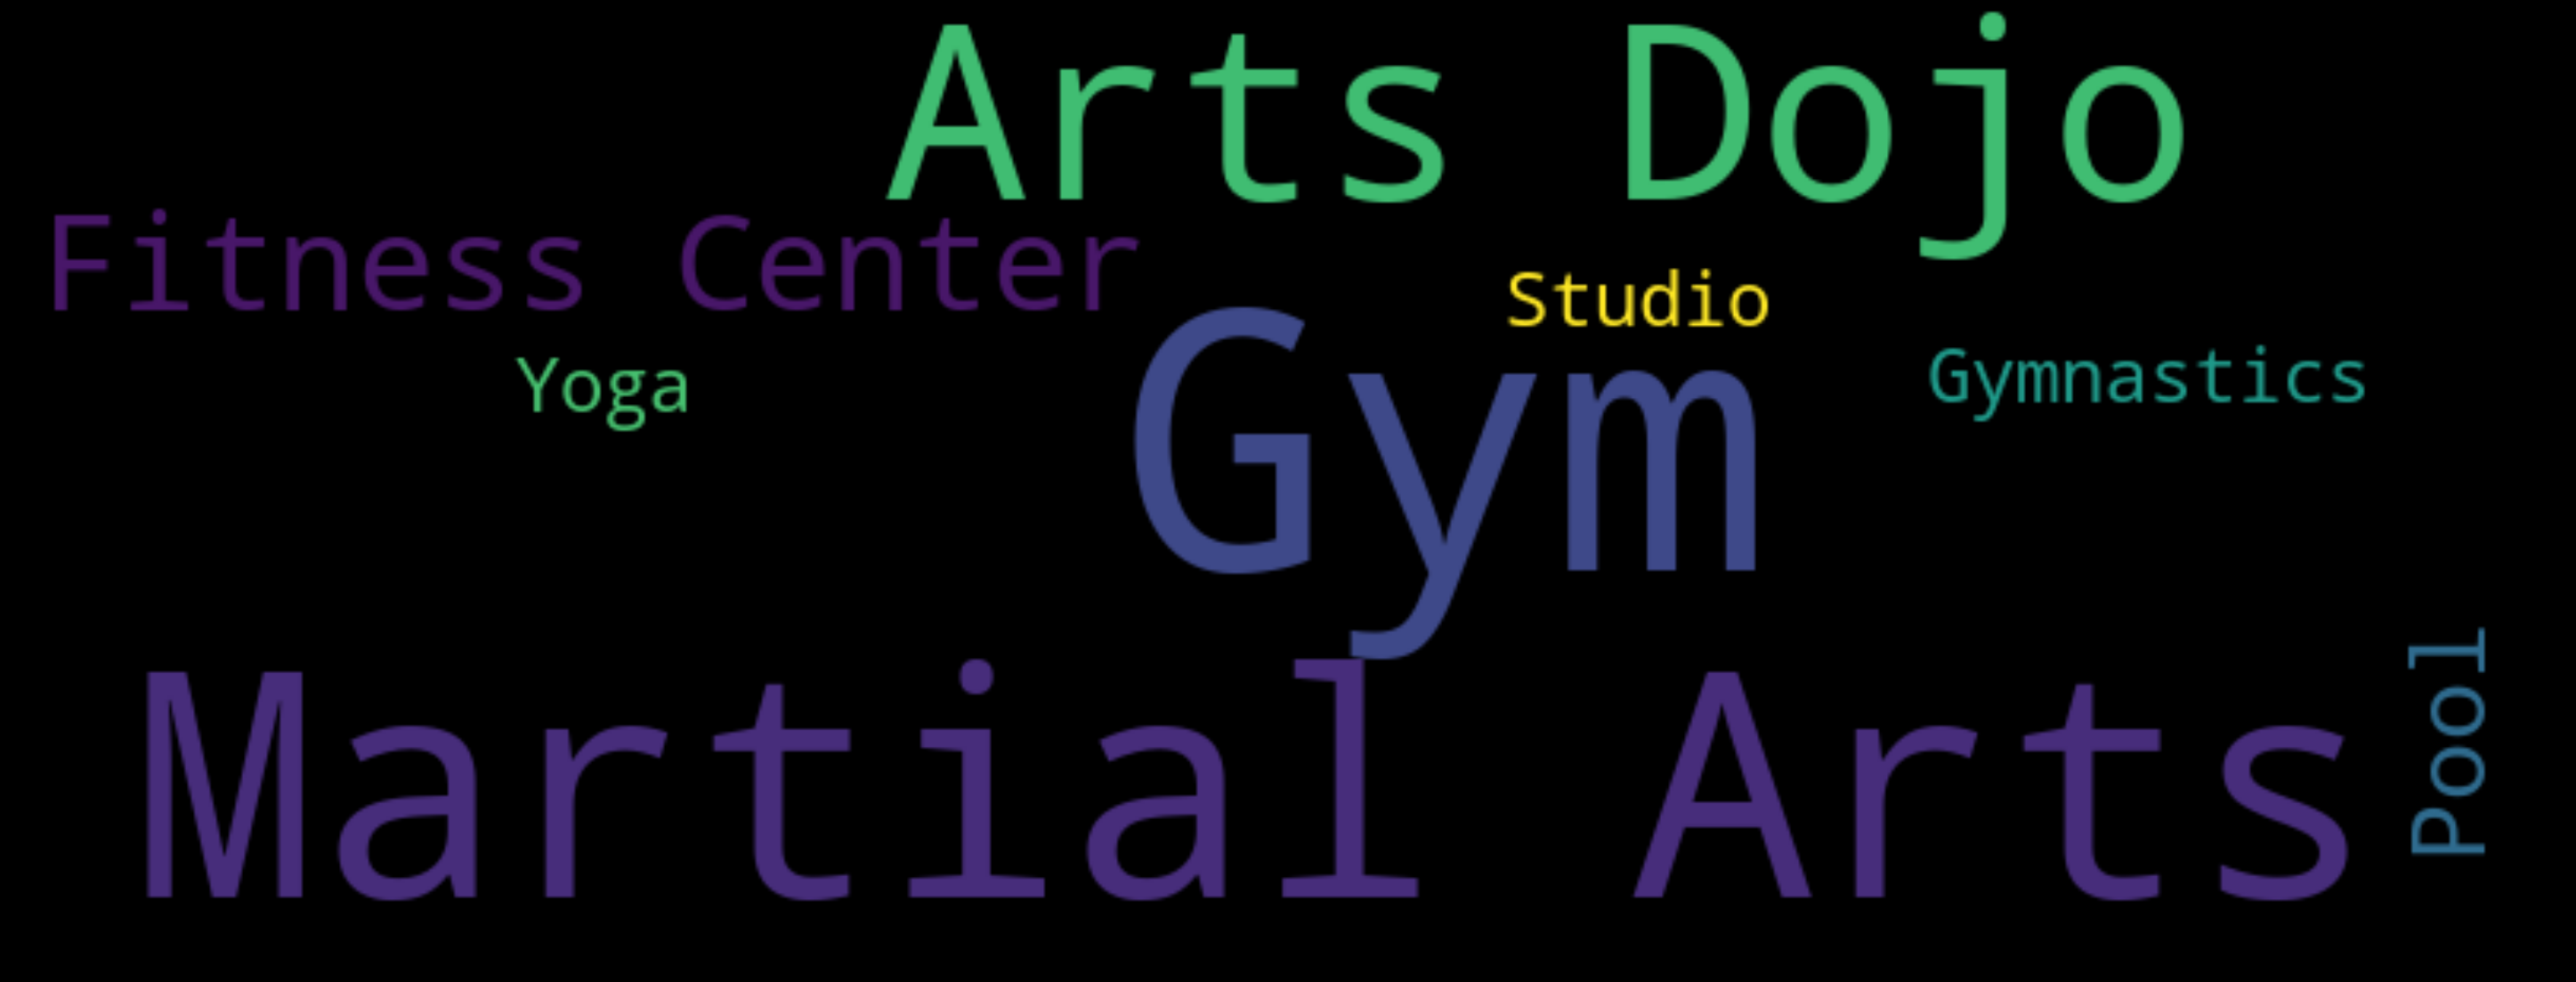

In [75]:
cluster1 = ny_merged.loc[ny_merged['Cluster Labels'] == 1]
text = cluster1['1st Most Common Venue']
wordcloud = WordCloud(
    width = 800,
    height = 300,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Cluster 2:

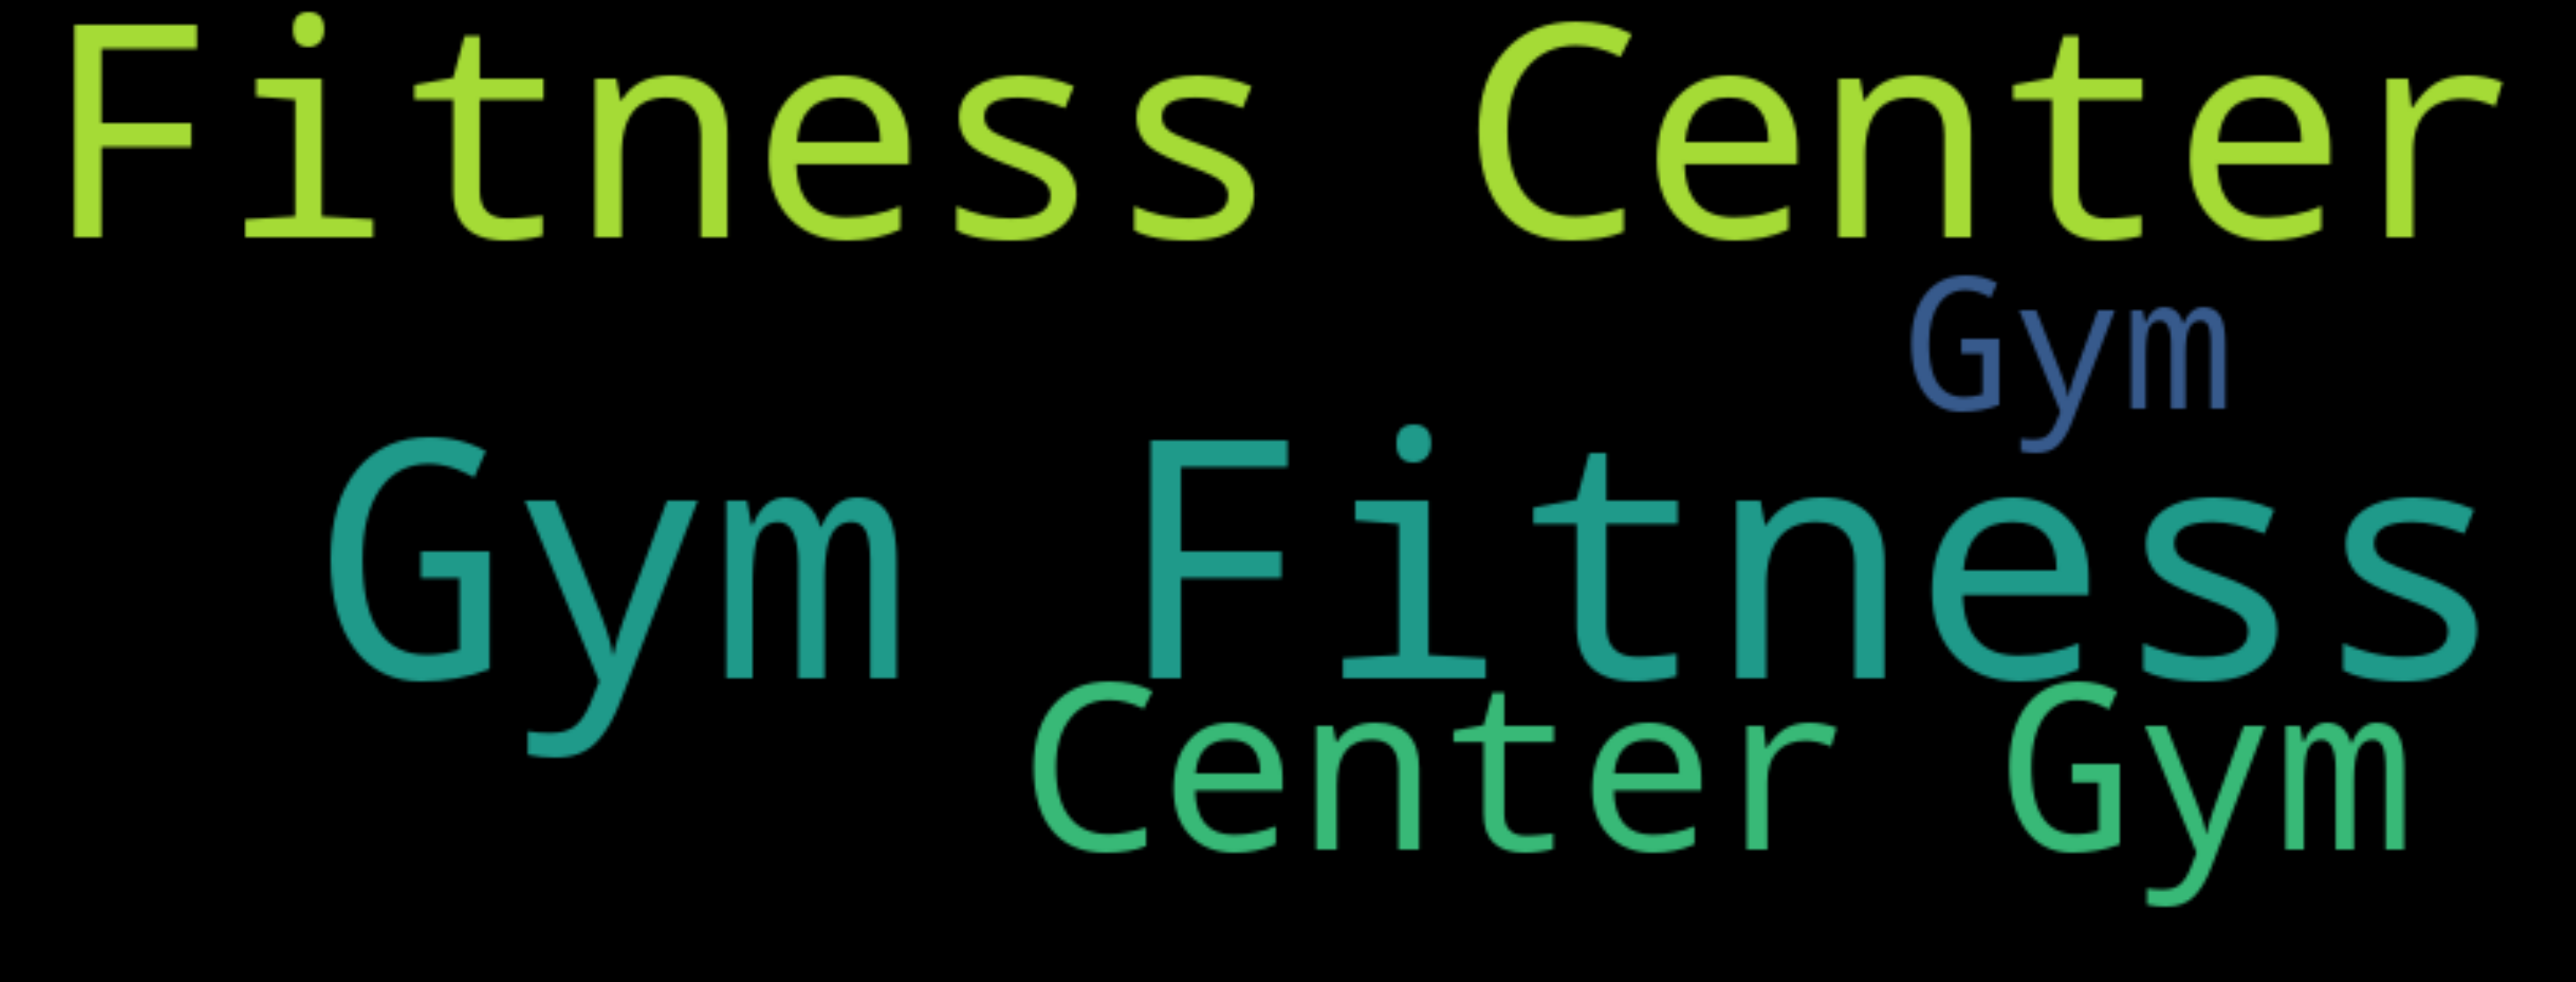

In [76]:
cluster2 = ny_merged.loc[ny_merged['Cluster Labels'] == 2]
text = cluster2['1st Most Common Venue']
wordcloud = WordCloud(
    width = 800,
    height = 300,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Cluster 3: 

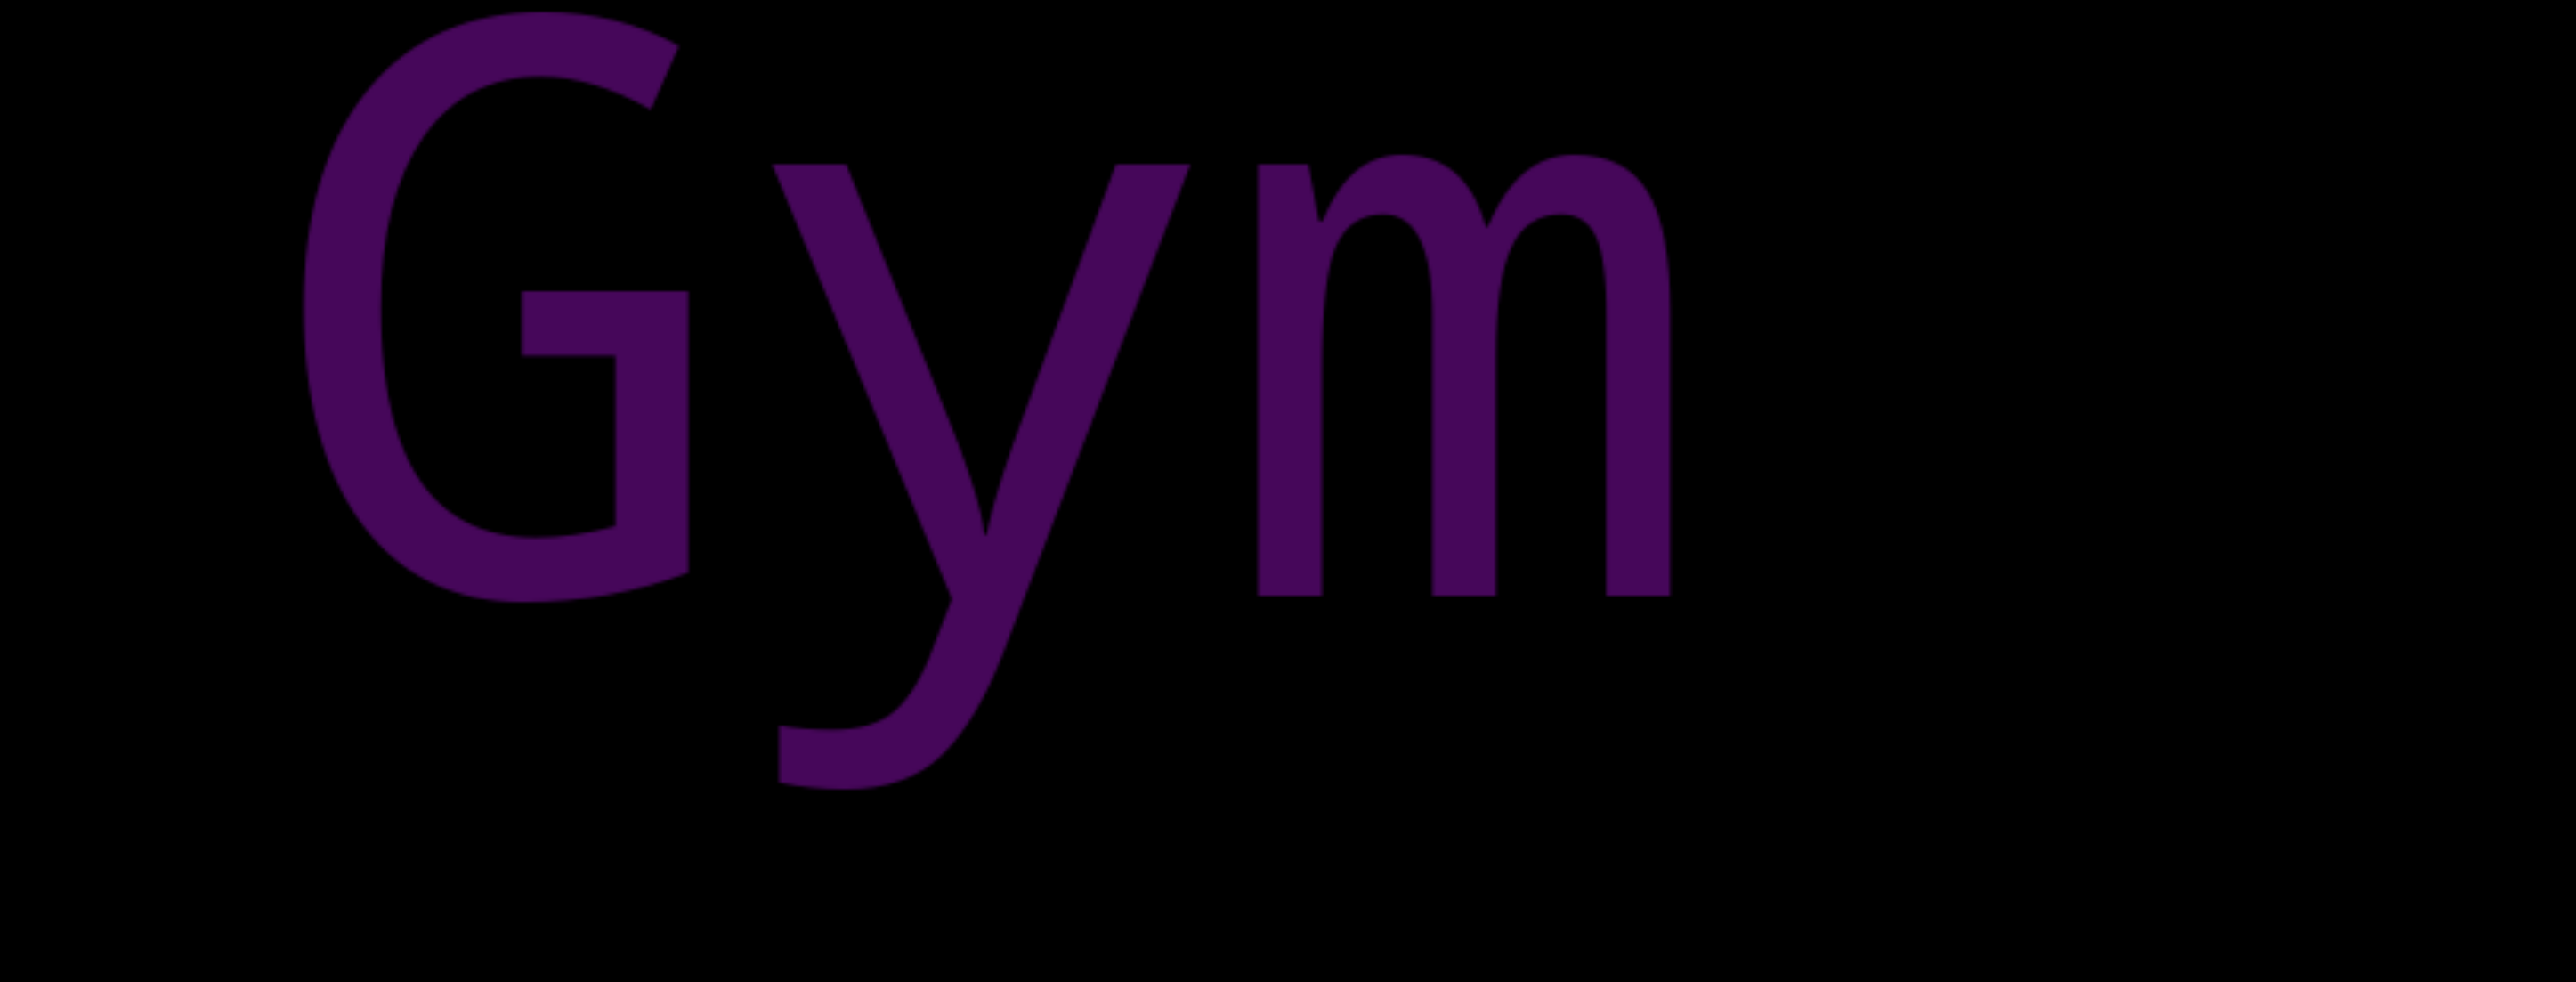

In [77]:
cluster3 = ny_merged.loc[ny_merged['Cluster Labels'] == 3]
text = cluster3['1st Most Common Venue']
wordcloud = WordCloud(
    width = 800,
    height = 300,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Cluster 4:

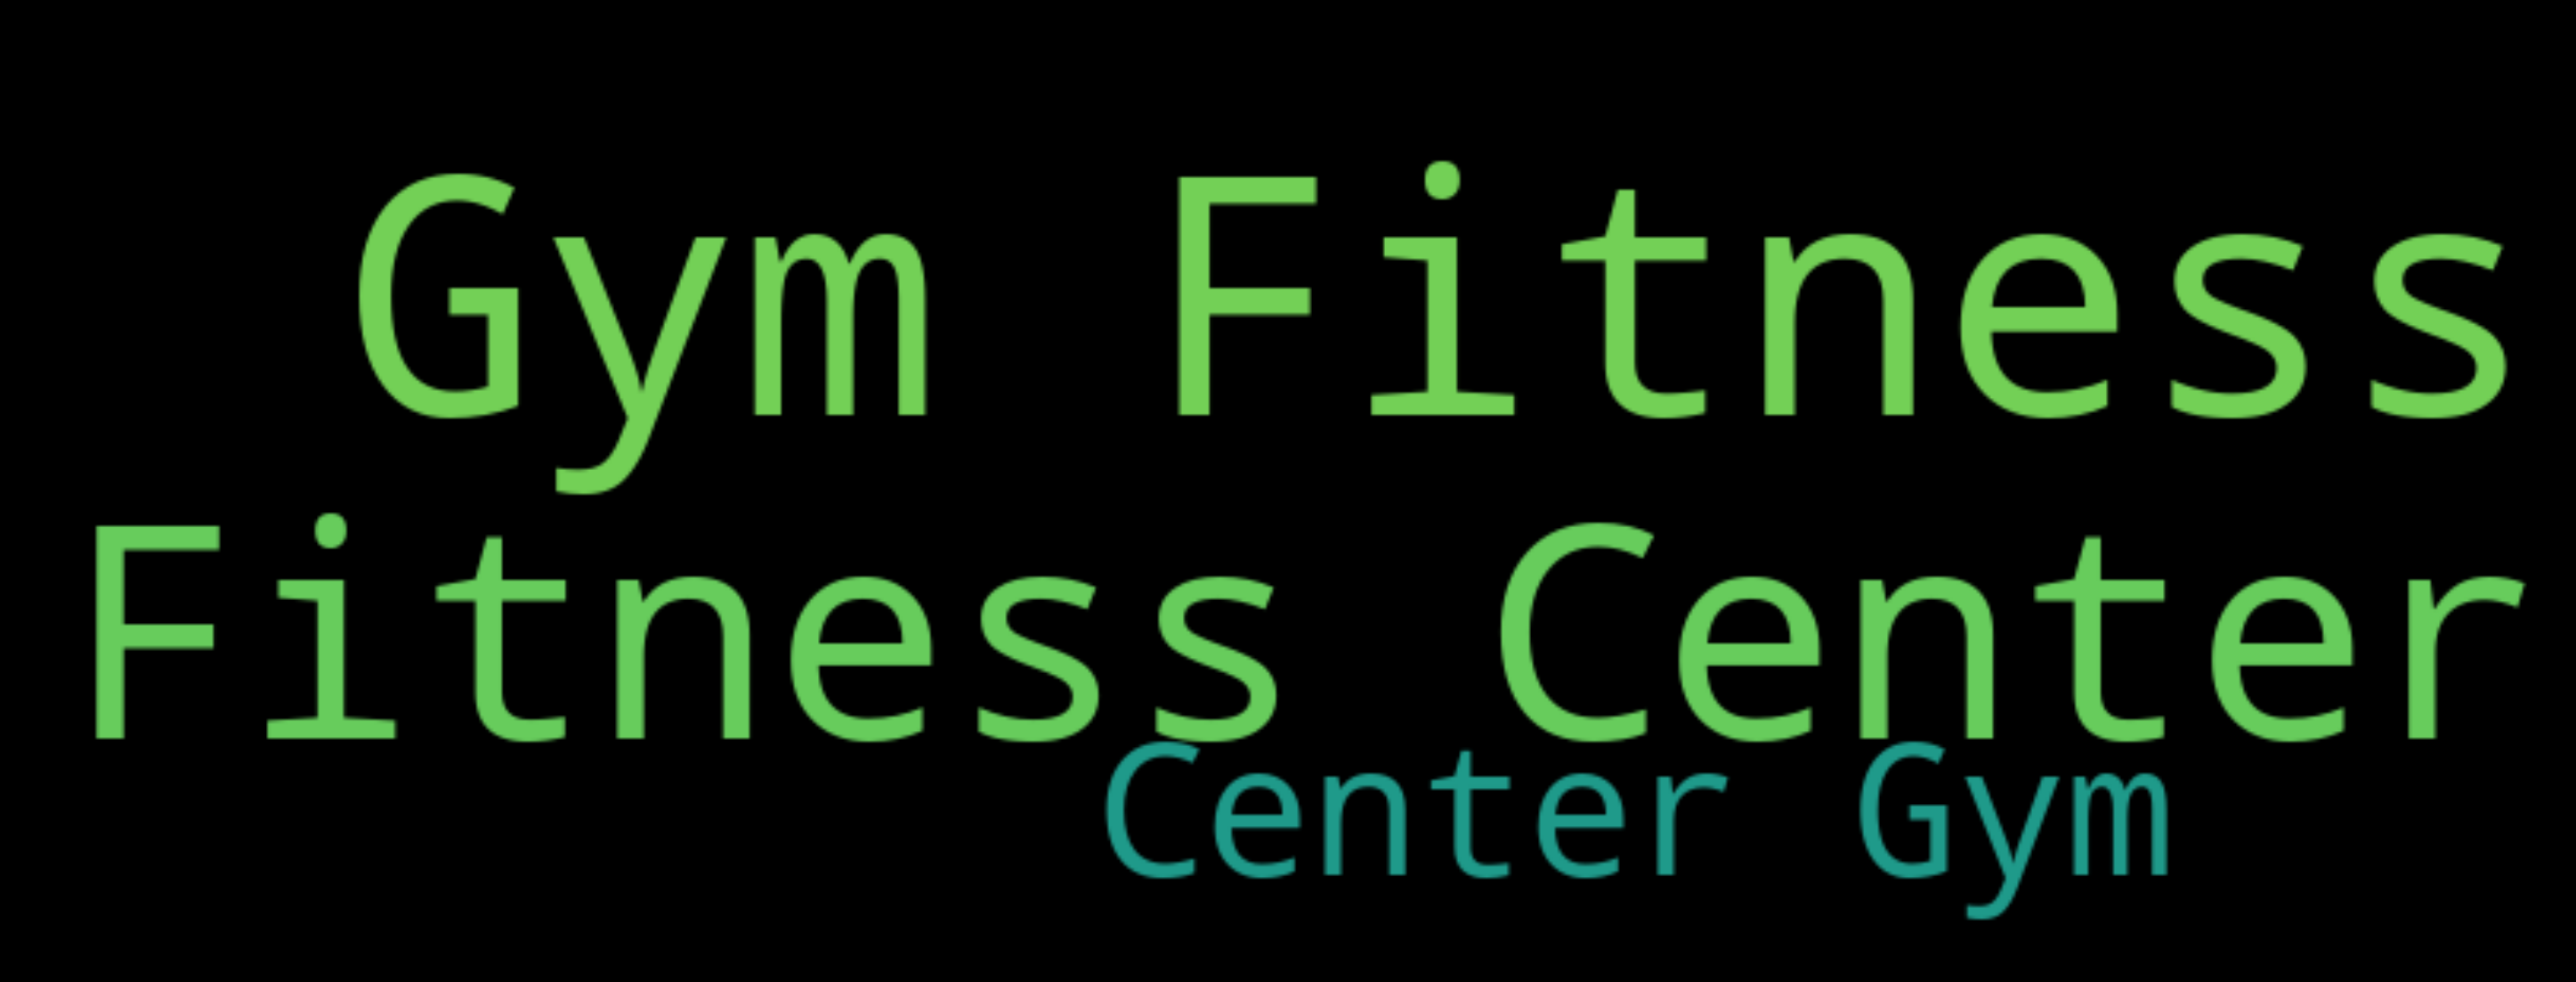

In [78]:
cluster4 = ny_merged.loc[ny_merged['Cluster Labels'] == 4]
text = cluster4['1st Most Common Venue']
wordcloud = WordCloud(
    width = 800,
    height = 300,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Cluster 5:

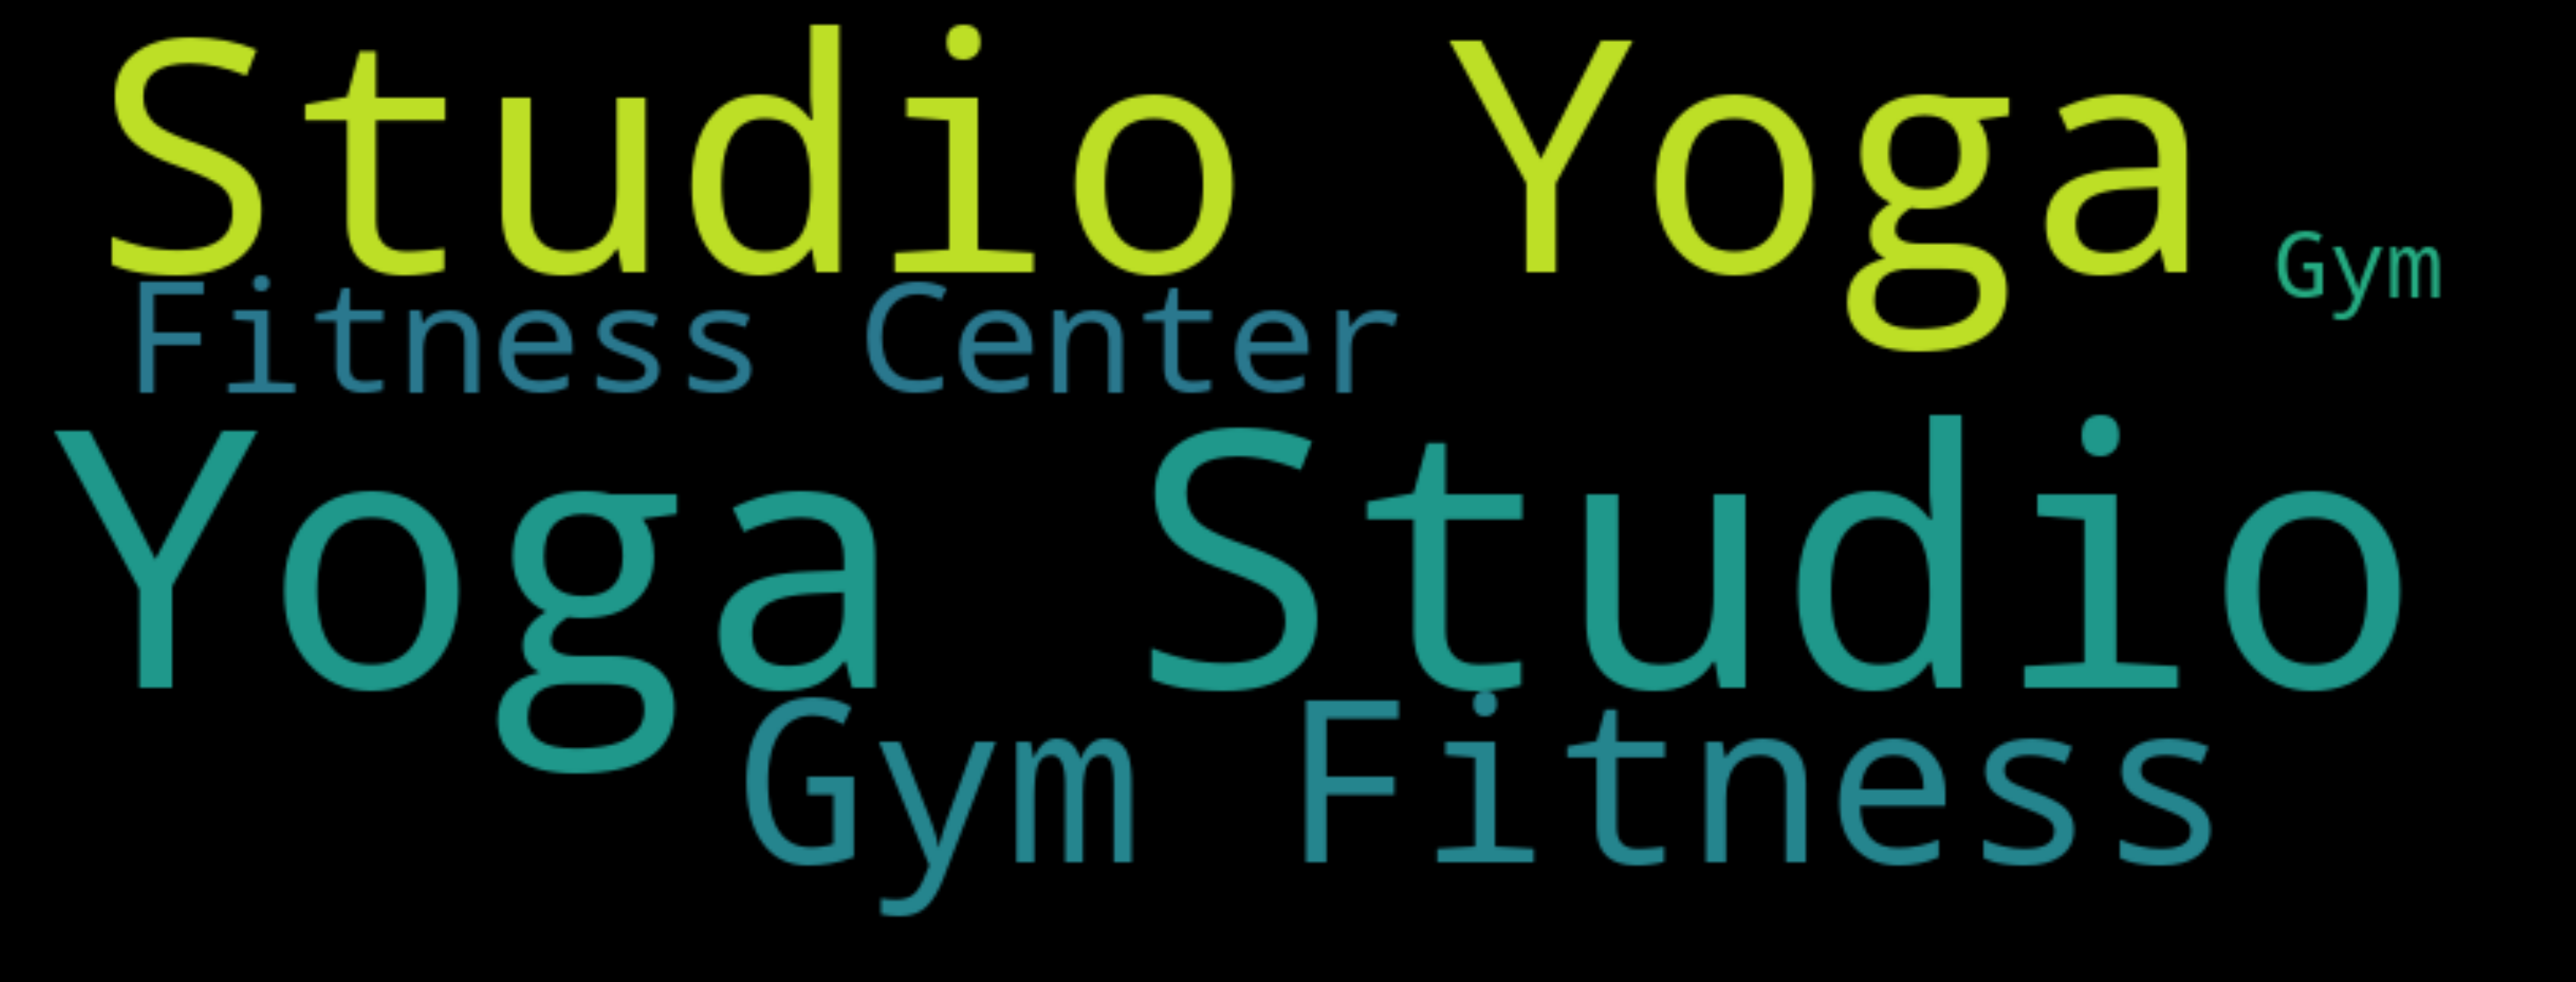

In [79]:
cluster5 = ny_merged.loc[ny_merged['Cluster Labels'] == 5]
text = cluster5['1st Most Common Venue']
wordcloud = WordCloud(
    width = 800,
    height = 300,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## RESULTS

Using the K-Means methodology, the New York neighborhoods were divided into five clusters and displayed on Folium Map (Python).
With geolocations added, various colors indicate belonging to a cluster.

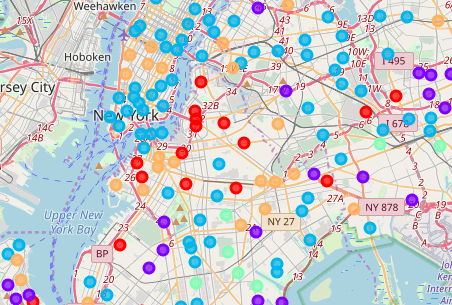

Let's use World Cloud to describe the most common venues, that were discovered using the described method and classified into the same cluster by K-Means (Machine Learning algorithm).

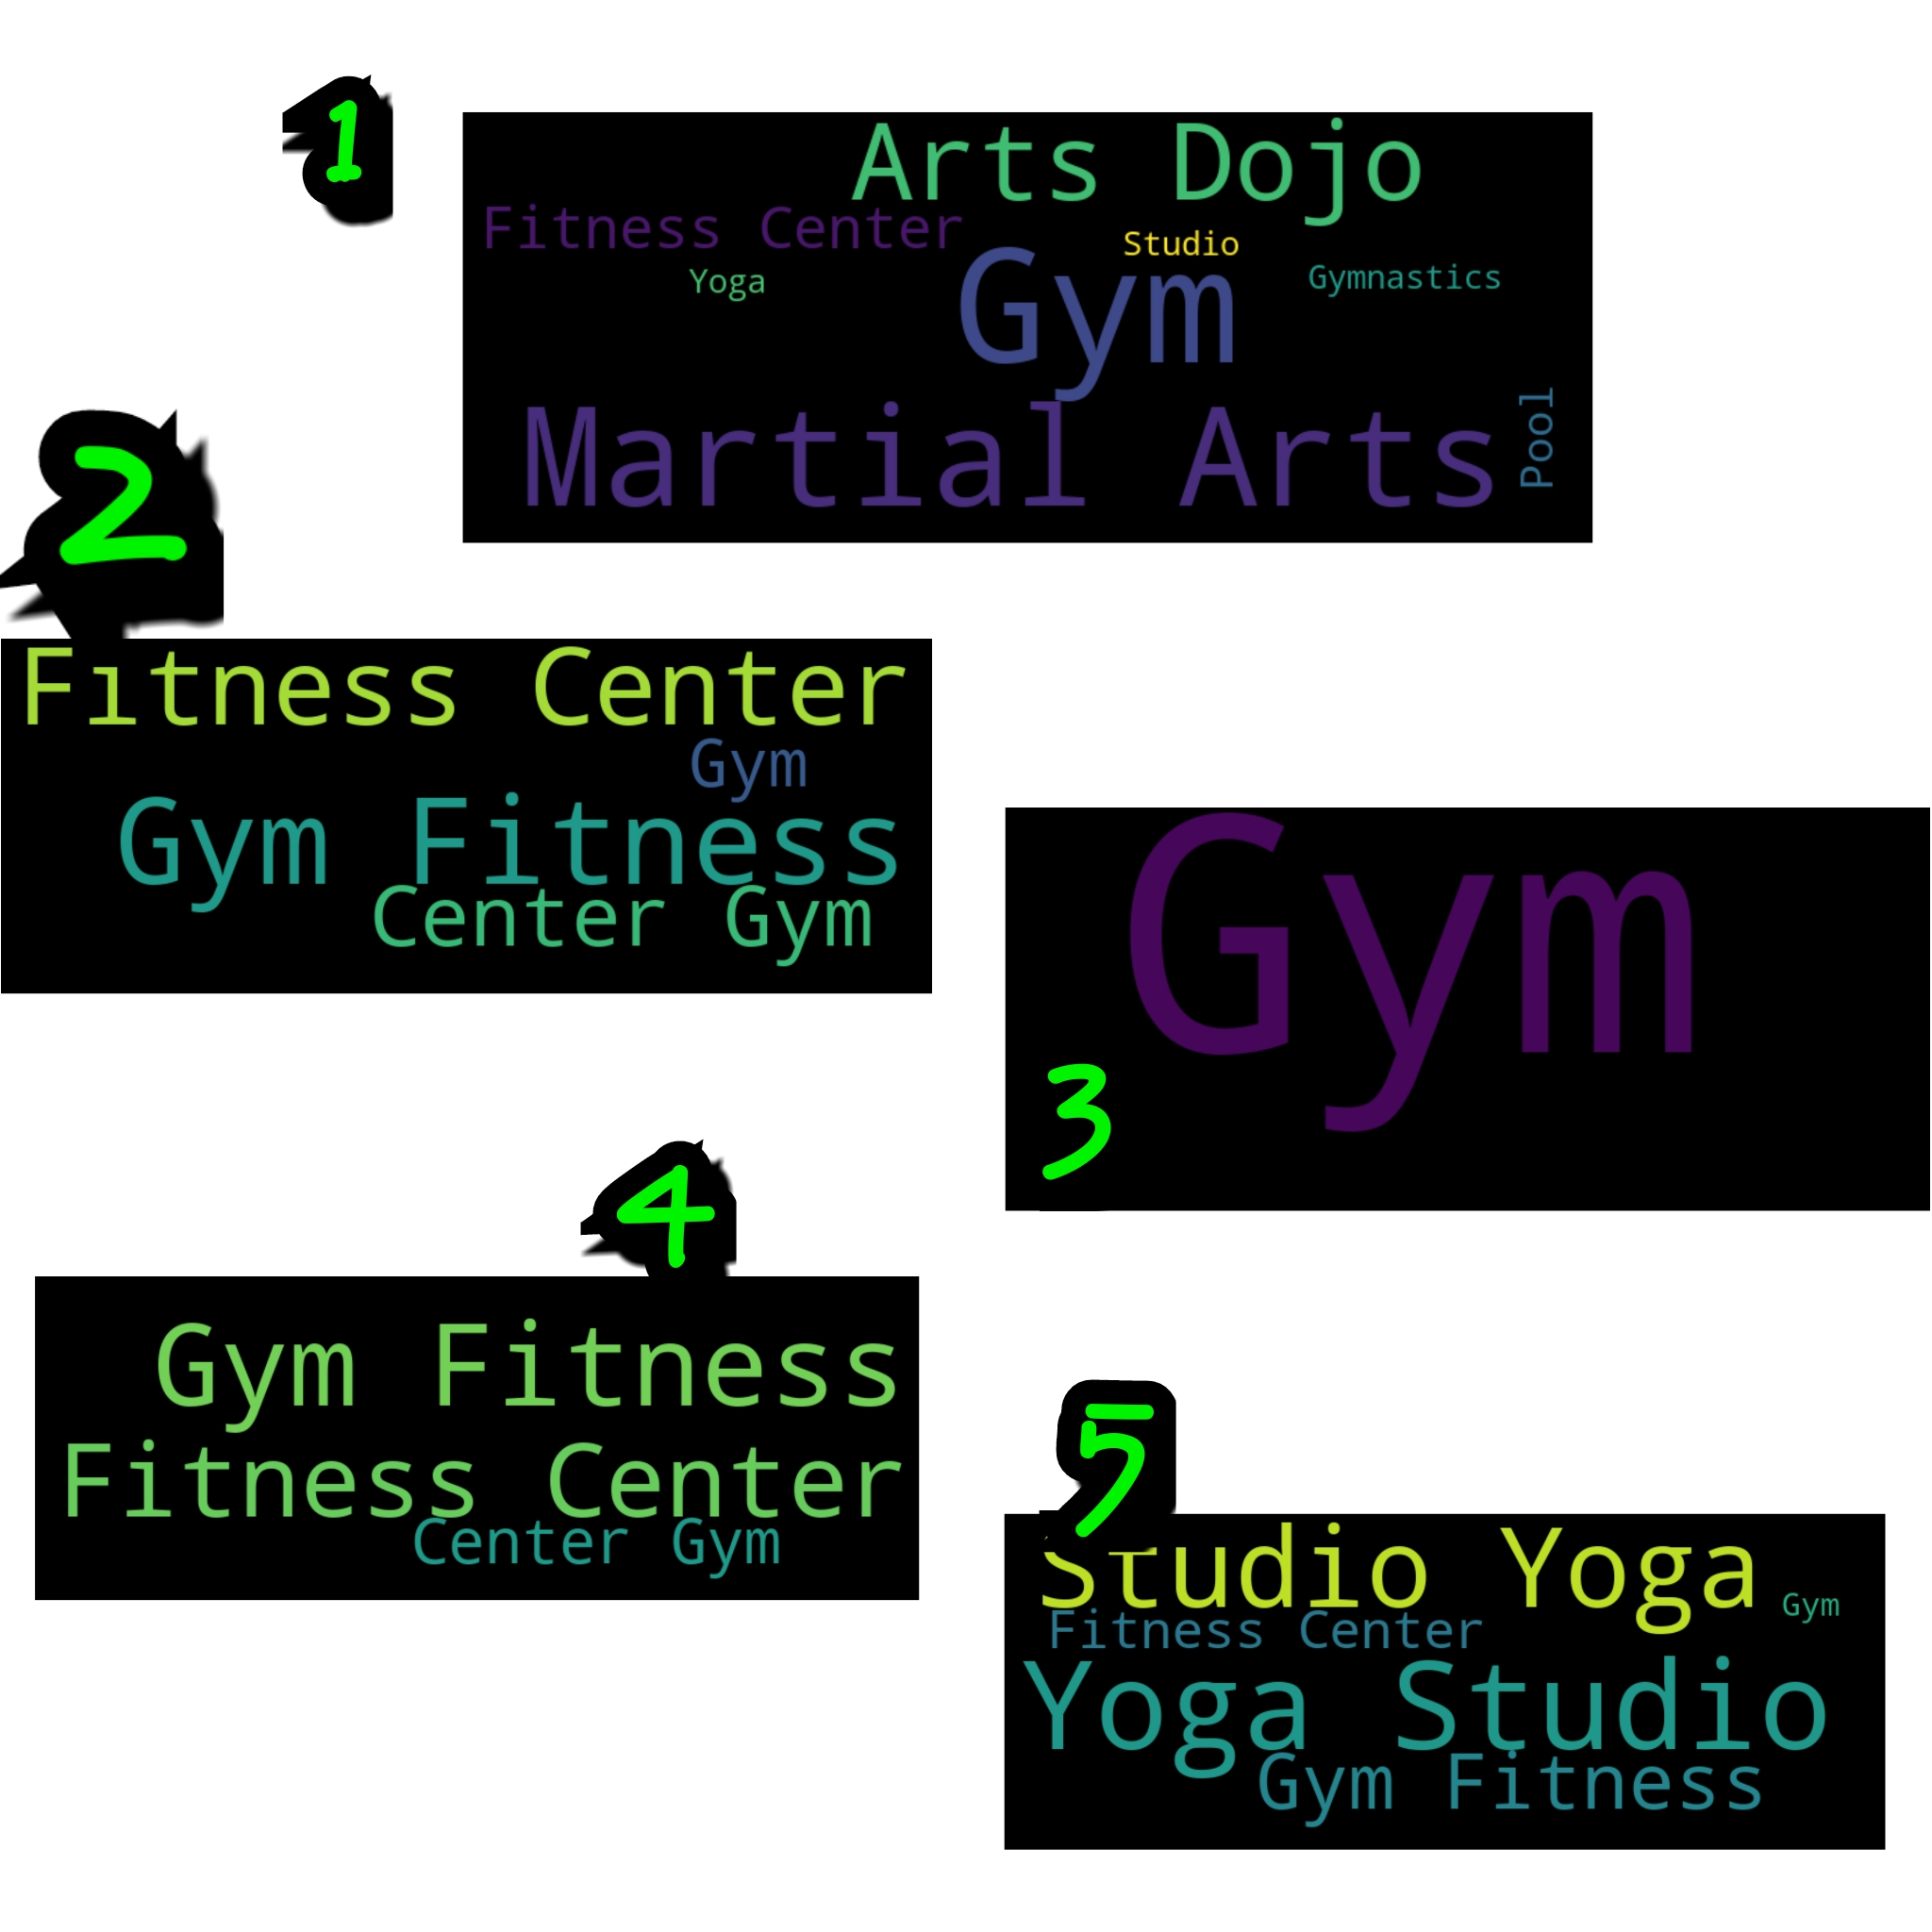

As you can see, each cluster is slightly different in terms of most common venues, our client can easily see, what types of sporting activities are most frequently there. 
However, the original request was to find out the highest density of gyms and fitness centers in New York. As we can see, Cluster 2 is not only the biggest one according the number of venues, it's also the densest one. That's why I would recommend for my client to move to Lower Manhattan, where the density of gyms is the biggest.

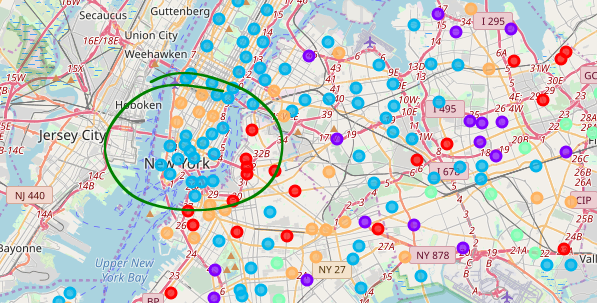

## DISCUSSION

K-Means method works well for classification of neighborhoods. What is debatable are the FourSquare data, as for the project I excluded venues that fall into category of Athletics_and_sports, which maybe should be taken into the consideration (category ID is mentioned in the code, it can be used anytime if needed). Category "Gyms / Fitness Centers" is considered. From this dataset, the most common venues categories are used for clustering hence comparing the neighborhoods.

To claim an objective classification you need to understand the data and it takes little experimenting find out the best K for K-Means algorithm, but that's well known problem.

## CONCLUSION

FourSquare API is very powerful if used correctly, its advantage is that people use it all around the world. I prefer discussion thread for every venue to learn references when I am looking for trying something new.

Using the described method, I learned Manhattan is the borrough with the highest density of gyms / fitness centers / martial arts dojos, which is what our client is looking for. In Manhattan, in particular Lower Manhattan, Cluster 2 venues and Cluster 4 venues are populated, whilst we can see from the WordCloud visualizations, Gyms and Fitness Centers are amongst the most common values (unlike Cluster 3, where the most common value is Gym).

The goal of the project was satisfied, but there is for sure a lot of space for improvements in this area.

